# Gaussian Mixture Models EM algorithm. KMeans

### Import data

In [65]:
import kagglehub
import pandas as pd
from matplotlib import pyplot as plt

train_path = kagglehub.dataset_download("kunalgupta2616/hackerearth-customer-segmentation-hackathon", path="avhacklive/Train.csv")
# test_path = kagglehub.dataset_download("kunalgupta2616/hackerearth-customer-segmentation-hackathon", path="avhacklive/Test.csv")
train = pd.read_csv(train_path)
# test = pd.read_csv(test_path)

In [66]:
train.head()

,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed
0,id_43823,28.0,management,single,tertiary,no,285.0,yes,no,unknown,26,jun,303.0,4.0,NaN,0,unknown,0
1,id_32289,34.0,blue-collar,married,secondary,no,934.0,no,yes,cellular,18,nov,143.0,2.0,132.0,1,other,0
2,id_10523,46.0,technician,married,secondary,no,656.0,no,no,cellular,5,feb,101.0,4.0,NaN,0,unknown,0
3,id_43951,34.0,services,single,secondary,no,2.0,yes,no,unknown,20,may,127.0,3.0,NaN,0,unknown,0
4,id_40992,41.0,blue-collar,married,primary,no,1352.0,yes,no,cellular,13,may,49.0,2.0,NaN,0,unknown,0


In [67]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                31647 non-null  object 
 1   customer_age                      31028 non-null  float64
 2   job_type                          31647 non-null  object 
 3   marital                           31497 non-null  object 
 4   education                         31647 non-null  object 
 5   default                           31647 non-null  object 
 6   balance                           31248 non-null  float64
 7   housing_loan                      31647 non-null  object 
 8   personal_loan                     31498 non-null  object 
 9   communication_type                31647 non-null  object 
 10  day_of_month                      31647 non-null  int64  
 11  month                             31647 non-null  object 
 12  last

### Preprocessing
- Cleaning data
- apply encoding 

<Axes: >

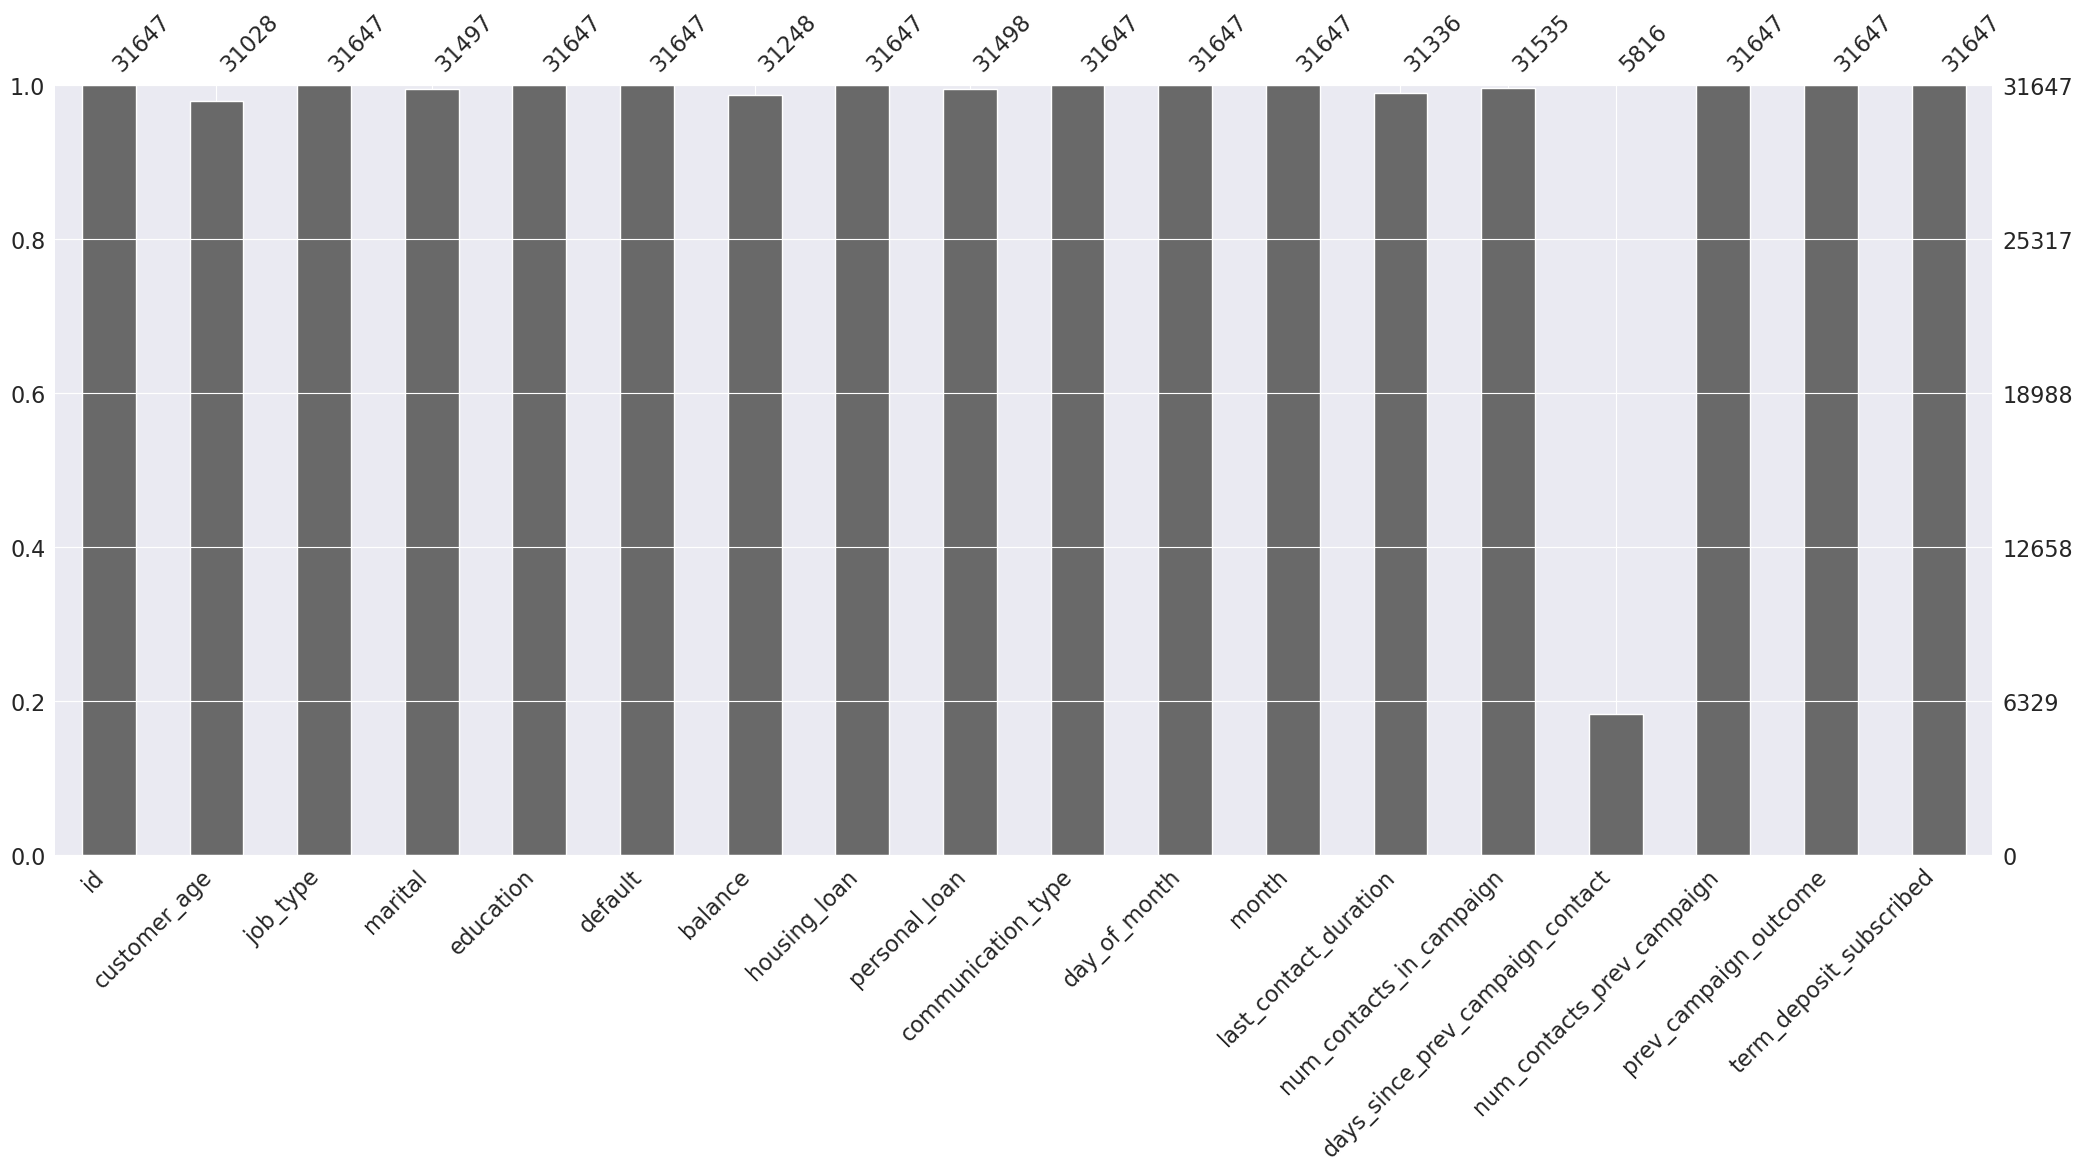

In [42]:
import missingno as msno
%matplotlib inline
msno.bar(train)

As we could observe there are some missing values for columns like *customer_age*, *days_since_prev_campaign_contact*. Especially *days_since_campaign_contact* have a huge gap in datas. That's why we will consider to delete it because it doesn't  represent a huge importance in classifying the customers groups.

In [68]:
train = train.drop(["id", "days_since_prev_campaign_contact"], axis=1)

from sklearn.preprocessing import LabelEncoder

to_encode = ['job_type', 'marital', 'education', 'default', 'housing_loan', 'personal_loan', 'communication_type', 'month', 'prev_campaign_outcome']
label_encoder = LabelEncoder()

encoded_classes = {}
for encoded in to_encode:
    train[encoded] = label_encoder.fit_transform(train[encoded])
    encoded_classes[encoded] = label_encoder.classes_

In [69]:
# list all columns that have nan values
train.columns[train.isna().any()].tolist()

['customer_age',
 'balance',
 'last_contact_duration',
 'num_contacts_in_campaign']

In [70]:
from sklearn.impute import SimpleImputer

# from reparo import CDI
# 
# inputer = CDI()
# train = inputer.fit_transform(train.to_numpy())
## the CDI takes 12m to execute

columns_to_input =['customer_age', 'balance', 'last_contact_duration', 'num_contacts_in_campaign']
inputer = SimpleImputer(strategy="mean")
train[columns_to_input] = inputer.fit_transform(train[columns_to_input])

### Applying Scaling 

In [71]:
from sklearn.preprocessing import StandardScaler
 
standard_scaler = StandardScaler()
scaled = standard_scaler.fit_transform(train)

### Using Silhouette score, find the best number of clusters for GMM (implemented in sklearn.)

In [7]:
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np

def draw_silhouette_plot(cluster, X, X_scaled, n_clusters):
    img, ax = plt.subplots(1,2, figsize=[12, 6])
    
    for j, x in enumerate([X, X_scaled]):
        cluster_labels = cluster.fit_predict(x)
        silhouette_avg = silhouette_score(x, cluster_labels)
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(x, cluster_labels)
        # The Silhouette Score ranges from -1 to 1
        ax[j].set_xlim([-1, 1])
        # The (n_clusters + 1) * 10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax[j].set_ylim([0, len(X) + (n_clusters + 1) * 10])
        ax[j].set_yticks([]) # Clear the yaxis labels
        ax[j].set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4,0.6, 0.8, 1])
        
        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
           
            ax[j].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,  alpha=0.7)
            # Compute the new y_lower for next plot
            y_lower = y_upper + 10 # 10 for the 0 samples
            # The vertical line for the average silhouette score of all the values
            ax[j].axvline(x=silhouette_avg, color="red", linestyle="--")
            ax[j].set_title(f'n_clusters = {n_clusters}; silhouette_avg={silhouette_avg:.2f}')
            ax[j].legend([ 'Silhouette Score' ] + [f'Cluster {i}' for i in range(n_clusters)])
    plt.show()

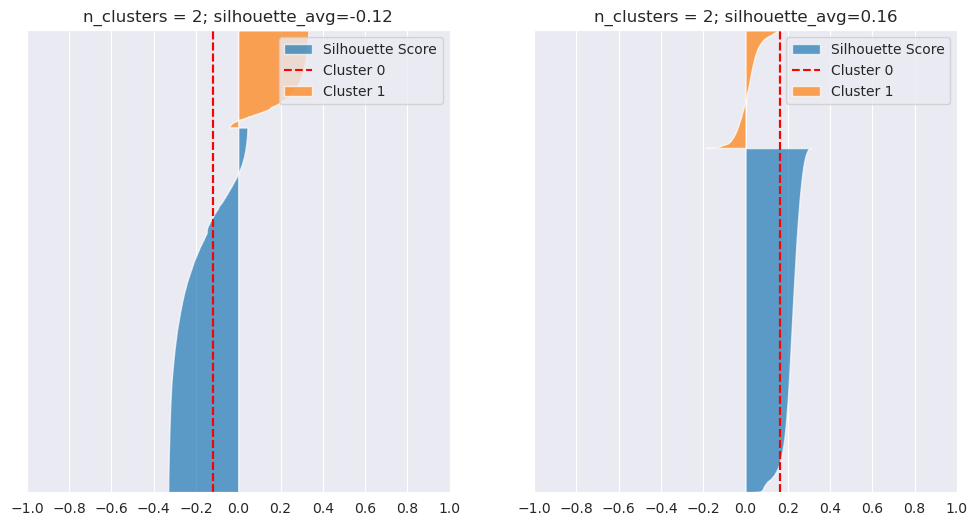

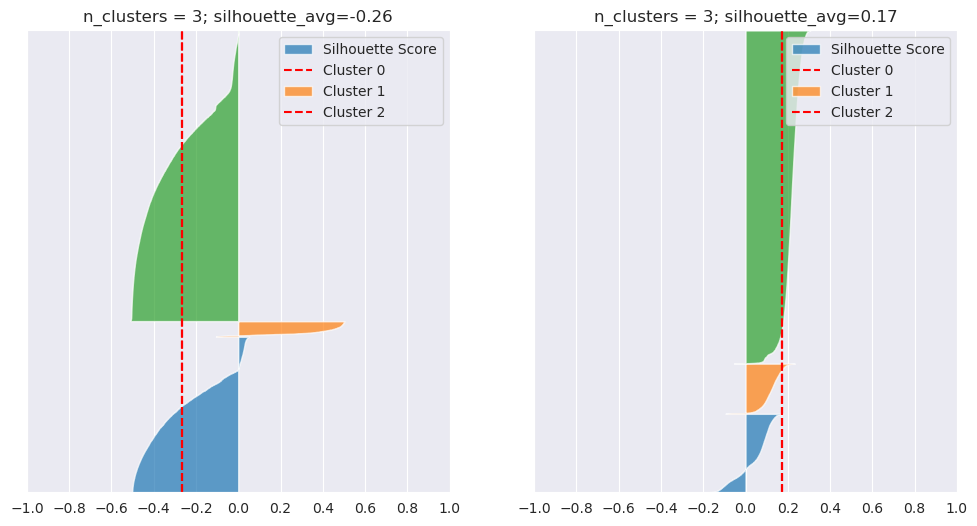

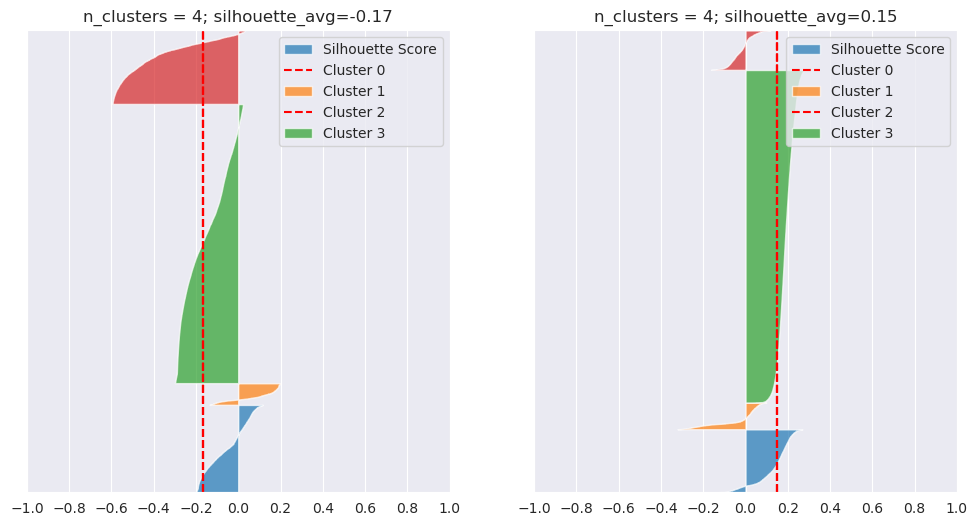

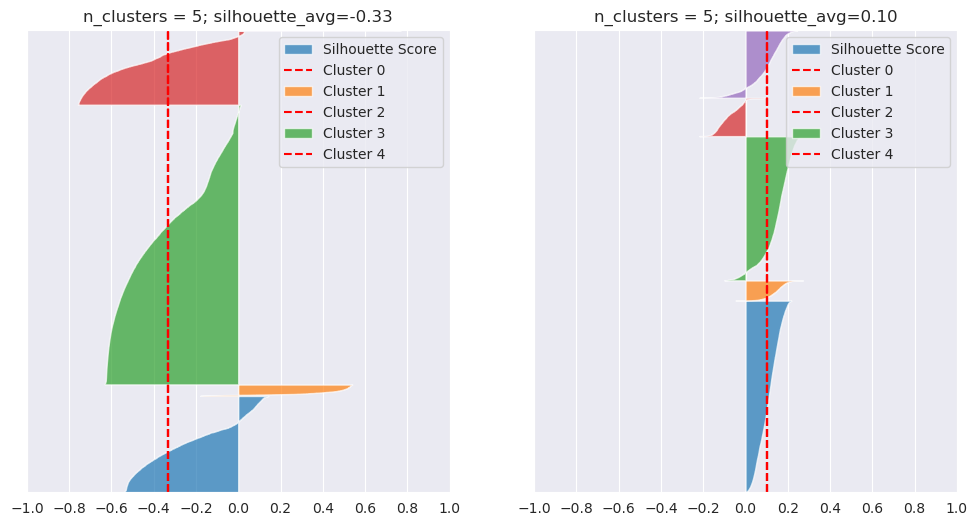

In [8]:
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture


for nr_clusters in range(2, 6):
    cluster = GaussianMixture(nr_clusters, random_state=11)
    draw_silhouette_plot(cluster,train, scaled, nr_clusters)

As we could observe there most probably *n_clusters*=2 judging by the *silhouette average score* which is **~ -0.1**. Again negative variables means that data are not in the right cluster. 

*post scriptum*. After applying silhouette score using KMeans there are clearer that GMM is a more probabilistic approach. Again not the most performant tool, but simple and fast.

*post post scriptum:* After some working I noticed that after applying standardization the final silhouette score is changing. So I begin to investigate. According to the SigmoidHB there is no harm what's so ever on the results if we apply standardization. And even online I found info that for clustering is recommended to apply some type scaling.  

### Using Silhouette score, find the best number of clusters for KMeans(implemented in sklearn.)

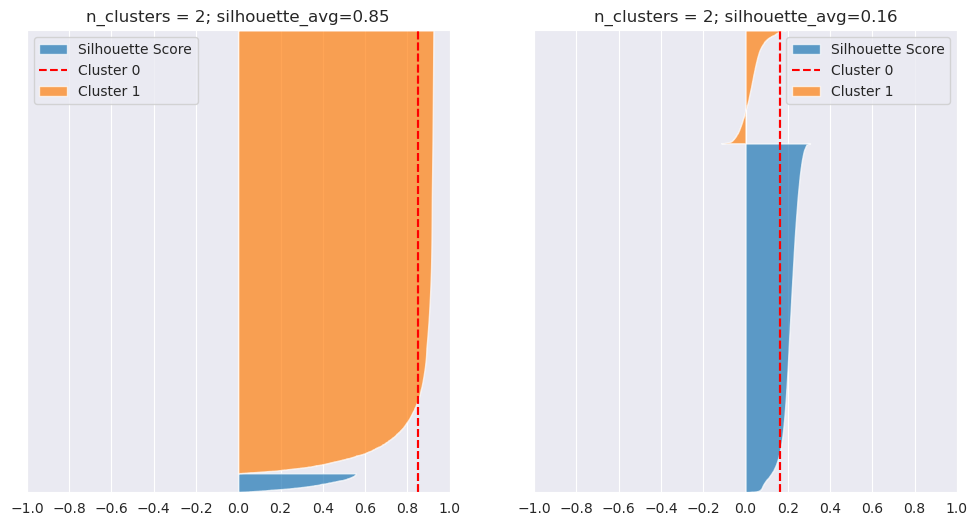

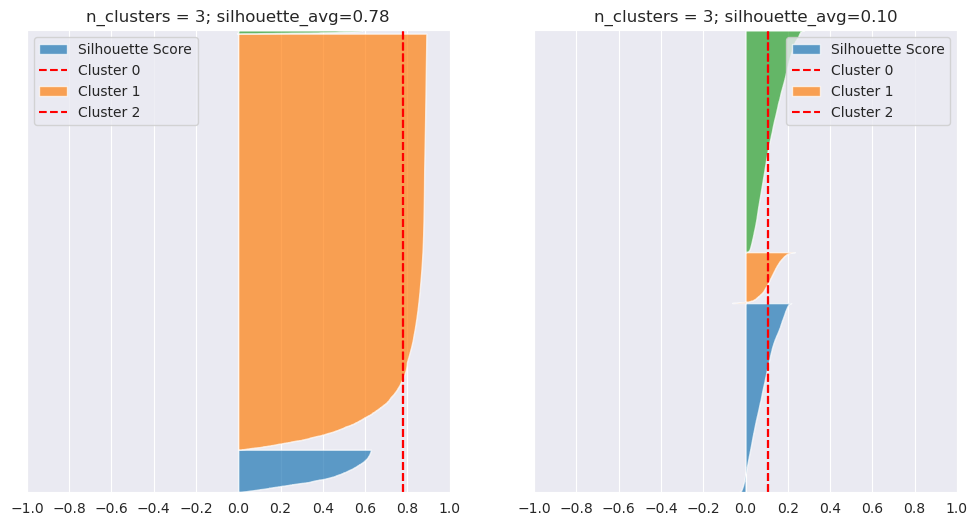

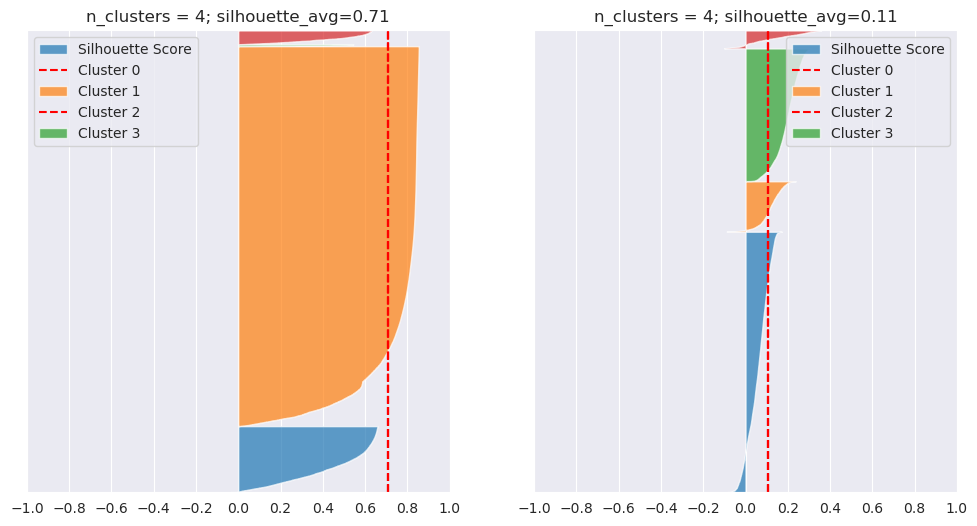

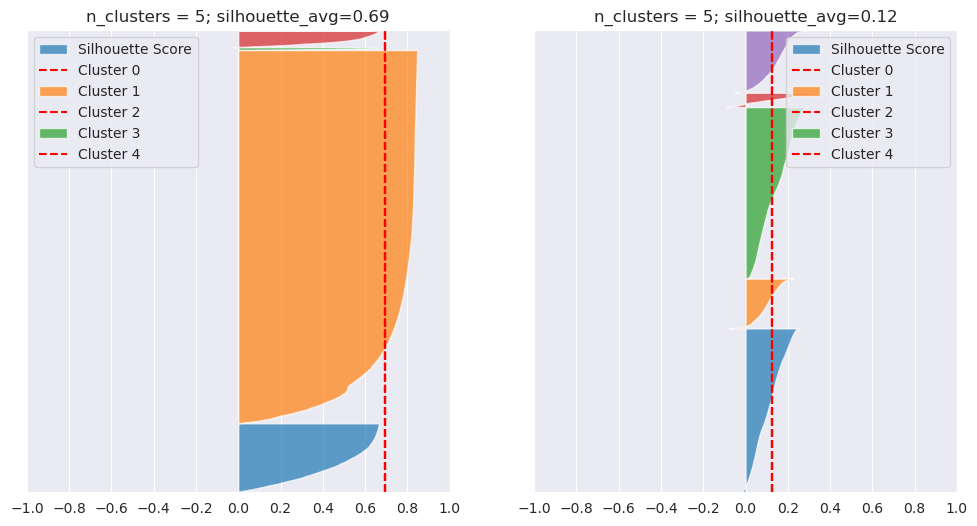

In [9]:
from sklearn.cluster import KMeans

for nr_clusters in range(2, 6):
    cluster = KMeans(nr_clusters, random_state=11)
    draw_silhouette_plot(cluster, train, scaled, nr_clusters)

Now we are talking! As could be proved the **n_clusters**=2 with *silhouette average score*=0.84. Again referring to the *GMM* the *KMeans* is more suited for clustering the results are far better than before, it may result by how these algorithms works GMM is focusing more on a probabilistic distribution approach.  

*post scriptum* Here we can se a contrary effect the scaled data shows a silhouette_avg lower than raw ones. So as a conclusion the GMM deals better with scaling while KMeans no.

### Clustering

GMM

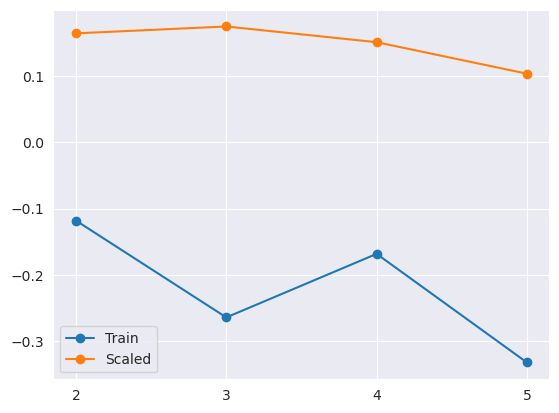

In [10]:
img, ax = plt.subplots()
legend_labels = ["Train", "Scaled"]
for i, x in enumerate([train, scaled]):
    silhouette_scores = []
    num_clusters_range = range(2, 6)
    
    for n_clusters in num_clusters_range:
        gmm = GaussianMixture(n_components=n_clusters, random_state=11)
        labels = gmm.fit_predict(x)
        score = silhouette_score(x, labels)
        silhouette_scores.append(score)
    plt.xticks(num_clusters_range)
    plt.plot(num_clusters_range, silhouette_scores, label=legend_labels[i], marker='o')
    plt.legend()
plt.show()

Again as mentioned earlier the highest silhouette score is at 2 clusters. (for GMM).

**post scriptum:Z** After applying the standard scaler it's could be observed that the there are differences between the number of final clusters. But we will assume the best version is the one with raw data. So this concludes that the optimal number of clusters is 2.    

KMeans

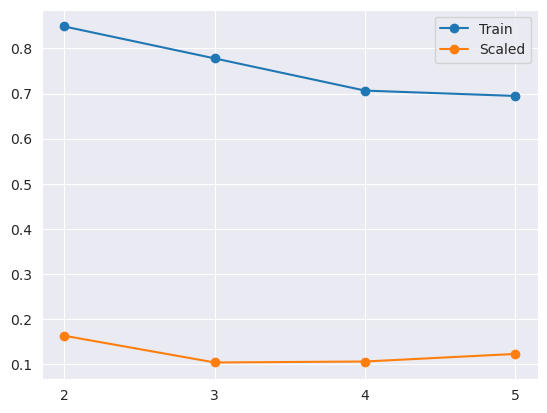

In [15]:
img, ax = plt.subplots()
legend_labels = ["Train", "Scaled"]
for i, x in enumerate([train, scaled]):
    silhouette_scores = []
    num_clusters_range = range(2, 6)
    
    for n_clusters in num_clusters_range:
        kmeans = KMeans(n_clusters, random_state=11)
        labels = kmeans.fit_predict(x)
        score = silhouette_score(x, labels)
        silhouette_scores.append(score)
    plt.xticks(num_clusters_range)
    plt.plot(num_clusters_range, silhouette_scores, label=legend_labels[i], marker='o')
    plt.legend()
plt.show()

One more time as mentioned earlier the optimal number of clusters are 2. Which corresponds with the results from the GMM.

**post scriptum:** Here there aren't changes in terms of number of clusters. Only the silhouette score varies from the raw version.

### Centroids (Means)
As I understand the task 

This below is just 

In [55]:
for encoded in encoded_classes:
    print(encoded, end="")
    print(encoded_classes[encoded])

job_type['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed' 'unknown']
marital['divorced' 'married' 'single' nan]
education['primary' 'secondary' 'tertiary' 'unknown']
default['no' 'yes']
housing_loan['no' 'yes']
personal_loan['no' 'yes' nan]
communication_type['cellular' 'telephone' 'unknown']
month['apr' 'aug' 'dec' 'feb' 'jan' 'jul' 'jun' 'mar' 'may' 'nov' 'oct' 'sep']
prev_campaign_outcome['failure' 'other' 'success' 'unknown']


GMM

In [73]:
gmm = GaussianMixture(2, random_state=11)
gmm_labels = gmm.fit_predict(scaled)

means = standard_scaler.inverse_transform(gmm.means_)

result = pd.DataFrame(data=means, columns=train.columns)
for encode in to_encode:
    result[encode] = result[encode].apply(lambda x: encoded_classes[encode][round(x)])

result

,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed
0,40.390560,management,married,secondary,no,1147.078041,yes,no,telephone,16.226848,jun,218.895606,2.993730,4.141132e-14,unknown,1.075529e-14
1,40.581645,management,married,secondary,no,2015.132221,yes,no,cellular,14.623409,jun,365.335949,2.141125,2.323430e+00,other,4.211782e-01


So what we have here is middle age maried persons that works in management that have a secondary studies with no fails in paying debts with a balance of ~1000 and ~2000. Both have housing loan but no personal loan, here another difference one group uses telephone and another cellular.
So the biggest difference is the balance and the communication_type

KMeans

In [76]:
kmeans = KMeans(2, random_state=11)
kmeans_labels = kmeans.fit_predict(train)

centroids = kmeans.cluster_centers_

result = pd.DataFrame(data=centroids, columns=train.columns)
for encode in to_encode:
    result[encode] = result[encode].apply(lambda x: encoded_classes[encode][round(x)])

result

,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed
0,43.368419,retired,married,secondary,no,12143.834749,no,no,telephone,15.891892,jun,265.645029,2.673524,0.626255,unknown,0.141313
1,40.314239,management,married,secondary,no,908.355098,yes,no,telephone,15.815432,jun,255.780374,2.781028,0.590142,unknown,0.105792


Here are easier to distinguish the 2 classes  could be observed that there is a group with older people, which already retired and with a bigger balance with no housing loan that uses telephone. And another class with younger people 40 that works in management with a smaller balance with a housing loan, also again uses telephone

# Conclusion
Overall we were able to extract two potential profiles of people. The Kmeans showed better results than Gaussian Mixture Model. Although there isn't a good idea to assume the possible profiles of persons from the centroids. As I did above the Kmeans returns a relatively mean data for a well distributed dataset an evident example could serve month that is in the middle of the year what a coincides. Also, LabelEncoding is not very suited for this type of application from the tables above could be observed that the job_type is almost always the same "management" this doesn't mean that all works in management this means that the management class was lucky to be in the middle of classes that describes job_type. The best solution for this problem is to apply HotEncoding (about which my mentor told me). I hope he will not notice this because I relly don't want to remake the homework. Well at least I understand now what to use and when.